In [62]:
import os
import time
import pandas as pd

import matplotlib.pyplot as plt
import statistics as s

def piec(s, l):
    fig1, ax1 = plt.subplots()
    ax1.pie(s, labels=l, autopct='%1.1f%%', startangle=90)
    ax1.axis('equal')
    plt.figure(figsize=(20,10)) 
    plt.show()

# apps

We have chosen 4 popular apps from Google Play:

In [ ]:
apps = {
    'reddit' : {
        'id' : 'com.reddit.frontpage',
        'color' : 'darkred',
        'linestyle' : 'solid',
        'marker': 'tri_down'
    },
    'snapchat': {
        'id' : 'com.snapchat.android',
        'color': 'yellow',
        'linestyle': 'dotted',
        'linewidth': '1',
        'marker': 'circle'
    },
    'soundcloud': {
        'id' : 'com.soundcloud.android',
        'color': 'orange',
        'linestyle': 'solid',
        'linewidth': '1',
        'marker': 'circle'
    },
    'whatsapp': {
        'id' : 'com.whatsapp',
        'color': 'gray',
        'linestyle': 'dotted',
        'linewidth': '1',
        'marker': 'circle'
    }
}

# import

### [1] raw, cleaned, classified
For each app, we import preprocessed (cleaned) datasets, as well as _exportable_ datasets.
The cleaned datasets are datasets that:
- were collected by scraping Google Play
- have had null values removed
- have had replyDates converted to boolean (1 or 0 indicating whether a review was replied to)
- have had short/meaningless reviews removed
- have had their review content classified into columns: sentiment, category
- have the following structure:

<table style="text-align:left;float:left;border:1px solid green;">
    <tr>
        <th>Timestamp</th>
        <th>Username</th>
        <th>Rating</th>
        <th>Review</th>
        <th>Sentiment</th>
        <th>Category</th>
        <th>Words</th>
        <th>Chars</th>
        <th>Likes</th>
        <th>ReplyDate</th>
        <th>Year</th>
        <th>Month</th>
        <th>Weekday Name</th>
    </tr>
    <tr>
        <td>08-08-2019 16:20</td>
        <td>George</td>
        <td>5</td>
        <td>Great app for reasons A, B, and C</td>
        <td>1</td>
        <td>Other</td>
        <td>Words</td>
        <td>27</td>
        <td>0</td>
        <td>0</td>
        <td>2019</td>
        <td>August</td>
        <td>Wednesday</td>
    </tr>
</table>
<br><br><br>

### [2] exportable, daily sum totals
The exportable datasets have the following structure:

<table style="float:left;border:1px solid red;">
    <tr>
        <th>Time</th>
        <th>ReviewCount</th>
        <th>Rating</th>
        <th>Words</th>
        <th>Chars</th>
        <th>Replies</th>
        <th>Negative</th>
        <th>Neutral</th>
        <th>Positive</th>
        <th>ImprovementRequest</th>
        <th>BugReport</th>
        <th>Other</th>
    </tr>
    <tr>
        <td>31-01-2020 16:20</td>
        <td>540</td>
        <td>2394</td>
        <td>13200</td>
        <td>32193</td>
        <td>44</td>
        <td>1</td>
        <td>19</td>
        <td>45</td>
        <td>411</td>
        <td>30</td>
        <td>30</td>
    </tr>
</table>
<br><br><br><br>
The following step ('select 40 datapoints'), we do based on these exportable datasets, whose columns consist of the <strong>daily</strong> sum totals of reviews, bug reports, etc. Daily averages can easily be calculated from these values where needed.

However, to perform the subsequent step after the selection ('sampling'), we need to go back to the datasets as they were before being "collapsed" into daily sum totals. We have to:
- retrieve all reviews pertaining to the each bucket (tsadf, peaks, valleys, random)
- from those reviews, make a balanced sampling of 100 reviews

In [15]:
rcc = {} # raw, cleaned, classified dataset
edf = {} # exportable daily sum totals

for x in apps:
    rcc[x] = pd.read_csv('data/gplay_clean/' + x + '_raw_clean.csv',
                         index_col="Timestamp",
                         parse_dates=True).loc['2019']
    edf[x] = pd.read_csv('data/exported/' + x + '_clean_2019.csv')
    
print(rcc.keys(),'\n',edf.keys())

dict_keys(['reddit', 'snapchat', 'soundcloud', 'whatsapp']) 
 dict_keys(['reddit', 'snapchat', 'soundcloud', 'whatsapp'])


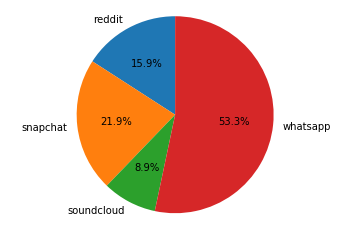

<Figure size 1440x720 with 0 Axes>

In [49]:
# distribution of reviews from raw/cleaned/classes
piec([len(rcc['reddit']), len(rcc['snapchat']), len(rcc['soundcloud']), len(rcc['whatsapp'])],
    rcc.keys())

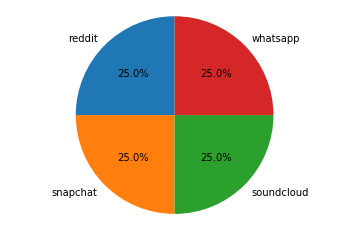

<Figure size 1440x720 with 0 Axes>

In [50]:
# distribution of reviews in exportable dataframes
piec([len(edf['reddit']), len(edf['snapchat']), len(edf['soundcloud']), len(edf['whatsapp'])],
    edf.keys())

# select 40 (days) datapoints

#### ten datapoints from time-series anomaly detection framework

In order to get the ten datapoints from the anomaly detection framework for each app, we simply load the exportable (anomaly detection framework compliant) datasets into the system, and have it output the indices of datapoints it thinks is anomalous.

This process is done manually, and the results are logged in the table below:

<table style="float: left;">
    <thead>
        <tr>
            <th>Reddit</th>
            <th>Snapchat</th>
            <th>Soundcloud</th>
            <th>WhatsApp</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>[423, 2, 3002, 13, 444, 5, 10, 1002, 1400, 400]</td>
            <td>[423, 2, 3002, 13, 444, 5, 10, 1002, 1400, 400]</td>
            <td>[423, 2, 3002, 13, 444, 5, 10, 1002, 1400, 400]</td>
            <td>[423, 2, 3002, 13, 444, 5, 10, 1002, 1400, 400]</td>
        </tr>
    </tbody>

#### ten datapoints from visual _peaks_

To get these ten datapoints, we plot the data for the whole year, and simply choose ten visible peaks.

In [29]:
s.mean(edf['reddit']['ReviewCount'])

188.67123287671234

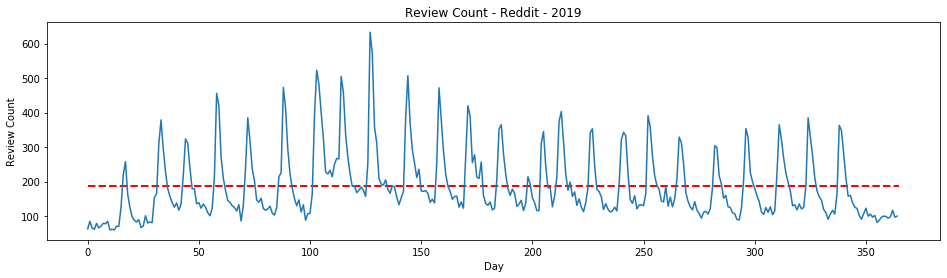

In [46]:
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(edf['reddit']['ReviewCount'])
ax.set(xlabel='Day', ylabel='Review Count', title='Review Count - Reddit - 2019')
plt.hlines(y=s.mean(edf['reddit']['ReviewCount']), xmin=0, xmax=len(edf['reddit']), colors='r', linestyles='--', lw=2)
plt.show()

In [42]:
print(f"Variance: {s.variance(edf['reddit'].ReviewCount)}",
f"Standard deviation: {s.stdev(edf['reddit'].ReviewCount)}")

Variance: 9770.798208640674 Standard deviation: 98.8473480101549


#### ten datapoints from visual _valleys_

#### ten random datapoints

Here we do a random sample (with varying seed), and make sure to only select indices that have not been selected by previous steps.

np.random.random_sample(10)

# sampling

here we perform a balanced (stratified, shuffled, representative) sample of 100 reviews from each of the above four buckets (tsadf, peaks, valleys, random)

# build xlsx

In [67]:
writer = pd.ExcelWriter('data/excel/example.xlsx', engine='xlsxwriter')

In [69]:
# Excel does not support Timezones
red_ntz = rcc['reddit'].copy()
red_ntz.index = red_ntz.index.tz_localize(None)

red_ntz.to_excel(writer, sheet_name='Test 1')
writer.save()